### Telemetry Hello World

This is a very a brief introduction to Spark and Telemetry in Python. You should have a look at the [tutorial](https://gist.github.com/vitillo/25a20b7c8685c0c82422) in Scala and the associated [talk](http://www.slideshare.net/RobertoAgostinoVitil/spark-meets-telemetry) if you are interested to learn more about Spark.

In [ ]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from moztelemetry.dataset import Dataset

%matplotlib inline

### Basics

We will use the Dataset API to fetch data.  Documentation can be found at: https://python-moztelemetry.readthedocs.io/en/stable/api.html#dataset

The goal of this example is to plot the startup distribution for each OS. Let's see how many parallel workers we have at our disposal:

In [ ]:
sc.defaultParallelism

We can look at the schema of the dataset we are interested in:

In [ ]:
Dataset.from_source('telemetry').schema

Let's create a Dataset of Telemetry submissions for a given submission date:

In [ ]:
pings_dataset = (
    Dataset.from_source('telemetry')
    .where(docType='main')
    #.where(appBuildId='20180721100146')
    .where(submissionDate='20180729')
    .where(appUpdateChannel="nightly")
)

Select only the properties we need and then take a 10% sample:

In [ ]:
pings = (
    pings_dataset
    .select(
        'clientId',
        buildId='application.buildId',
        content_paint='payload.processes.content.histograms.CONTENT_PAINT_TIME.values',
        tab_switch='payload.histograms.FX_TAB_SWITCH_TOTAL_E10S_MS.values',
        checkerboardin='payload.processes.gpu.histograms.CHECKERBOARD_SEVERITY.values',
        osName='environment.system.os.name',
        gfx='environment.system.gfx')
    .records(sc, sample=1)
)

In [ ]:
#pings = (
#    pings_dataset
#    .records(sc, sample=0.01)
#)
#pings.take(1)

In [ ]:
pings.count()

In [ ]:
pings.take(4)

In [ ]:
# We add two extra steps. The first rewrites the ping to have some
# information more easily accessible (like the primary adapter),
# and the second step removes any pings that don't have adapter
# information.
def rewrite_ping(p):
    adapters = p.get('gfx', None).get('adapters', None)
    if not adapters:
        return None
    adapter = adapters[0]
            
    p['adapter'] = adapter
            
    # Convert the version to a tuple of integers.
    #if 'driverVersion' in adapter:
    #    p['driverVersion'] = [int(n) for n in adapter['driverVersion'].split('.') if n.isdigit()]
    return p

def filter_ping(p):
    return 'adapter' in p
rpings = pings.map(rewrite_ping).filter(filter_ping)
rpings = rpings.cache()
rpings.count()

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *Dataset.select()*.

In [ ]:
subset = (
    rpings
    .map(lambda p: (p['clientId'], p))
    .reduceByKey(lambda p1, p2: p1)
    .map(lambda p: p[1])
)

Caching is fundamental as it allows for an iterative, real-time development workflow:

In [ ]:
cached = subset.cache()

How many pings are we looking at?

In [ ]:
cached.count()

In [ ]:
cached.filter(lambda p: p['checkerboardin']).count()

In [ ]:
cached = cached.filter(lambda p: "features" in p["gfx"])
cached = cached.filter(lambda p: "wrQualified" in p["gfx"]["features"])
cached.count()

In [ ]:
wrQualified = cached.filter(lambda p: p["gfx"]["features"]["wrQualified"]["status"] == "available" )
wrQualified.count()

In [ ]:
cached.filter(lambda p: p['checkerboardin']).map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

In [ ]:
checked = cached.filter(lambda p: p['checkerboardin']).filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
checked.map(lambda p: p["gfx"]["D2DEnabled"]).countByValue()

In [ ]:
wrQualified.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

In [ ]:
wrQualified.take(1)

In [180]:
wrEnabled = wrQualified.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
wrDisabled = wrQualified.filter(lambda p: p["gfx"]["features"]["compositor"] == "d3d11")
wrEnabled.count(), wrDisabled.count()

(1437, 5685)

In [167]:
wrDisabled3.filter(lambda p: p["checkerboardin"]).count()

687

In [181]:
wrDisabled2 = wrDisabled.sample(False, wrEnabled.count()/(wrDisabled.count()*1.0))
wrDisabled3 = wrDisabled.sample(False, wrEnabled.count()/(wrDisabled.count()*1.0))
wrDisabled = wrDisabled.sample(False, wrEnabled.count()/(wrDisabled.count()*1.0))

In [182]:
wrDisabled3.count(), wrDisabled.count(), wrDisabled2.count(), wrEnabled.count()

(1410, 1467, 1475, 1437)

In [ ]:
wrQualified.map(lambda p: p['buildId']).countByValue()

In [ ]:
normandy = wrQualified.filter(lambda p: p['buildId'] == '20180729100102')
normandy.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()
normandy.map(lambda p: p["adapter"]["deviceID"]).countByValue()


Let's group the startup timings by OS:

In [ ]:
grouped = (
    cached
    .map(lambda p: (p['osName'], p['firstPaint']))
    .groupByKey()
    .collectAsMap()
)

And finally plot the data:

In [ ]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type='axes')
plt.ylabel('log10(firstPaint)')
plt.show()

In [ ]:
plt.title('startup distribution for Windows')
plt.ylabel('count')
plt.xlabel('log10(firstPaint)')
frame['Windows_NT'].plot(kind='hist', bins=50, figsize=(14, 7))

### Histograms

Let's extract a histogram of GC_MARK_MS (time spent running JS garbage collection mark phase) from the submissions:

(see https://developer.mozilla.org/en-US/docs/Web/JavaScript/Memory_Management for more information)

In [ ]:
histograms = (
    pings_dataset
    .select(GC_MARK_MS_content='payload.processes.content.histograms.GC_MARK_MS.values',
            GC_MARK_MS_parent='payload.histograms.GC_MARK_MS.values')
    .records(sc, sample=0.05)
)

- `payload.histograms.GC_MARK_MS.values` is a path to the GC_MARK_MS values of the parent (main) process
- `payload.processes.content.histograms.GC_MARK_MS.values` is a path to the GC_MARK_MS values of the child processes

Let's aggregate the histogram over all submissions and plot it as a histogram.  Since the parent and child processes are recorded separately, we can create a histogram for each one and then add them together.

Each histogram is a pandas series where the index is the bucket and the value is the count.

In [ ]:
def aggregate_series(s1, s2):
    """Function to sum up series; if one is None, return other"""
    if s1 is None:
        return s2
    if s2 is None:
        return s1
    return s1.add(s2, fill_value=0)

In [ ]:


aggregated_enabled = (
    wrEnabled
    .map(lambda p: pd.Series(p['content_paint']))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    wrDisabled2
    .map(lambda p: pd.Series(p['content_paint']))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

In [ ]:
aggregated_disabled.sum()

In [ ]:
aggregated_enabled.sum()

In [ ]:
aggregated_disabled.loc[0:7].sum()/aggregated_disabled.sum()

In [ ]:
aggregated_enabled.loc[0:7].sum()/aggregated_enabled.sum()

In [ ]:
aggregated_disabled.loc[16].sum()/aggregated_disabled.loc[16:].sum()


In [ ]:
aggregated_enabled.loc[16].sum()/aggregated_enabled.loc[16:].sum()


In [ ]:
aggregated_enabled[22:].sum()

In [ ]:
aggregated_disabled[22:].sum()

In [ ]:
percent_enabled = aggregated_enabled[:].map(lambda x: x/aggregated_enabled[0:].sum())
percent_disabled = aggregated_disabled[:].map(lambda x: x/aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.plot(kind='bar', figsize=(15, 7))


In [ ]:
(100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))

In [ ]:
tab_aggregated_enabled = (
    wrEnabled
    .map(lambda p: pd.Series(p['tab_switch']))
    .reduce(aggregate_series)
)
tab_aggregated_enabled.index = [int(i) for i in tab_aggregated_enabled.index]
tab_aggregated_enabled = tab_aggregated_enabled.sort_index()

tab_aggregated_disabled = (
    wrDisabled2
    .map(lambda p: pd.Series(p['tab_switch']))
    .reduce(aggregate_series)
)
tab_aggregated_disabled.index = [int(i) for i in tab_aggregated_disabled.index]
tab_aggregated_disabled = tab_aggregated_disabled.sort_index()

In [ ]:
percent_enabled = tab_aggregated_enabled[0:].map(lambda x: x/tab_aggregated_enabled[0:].sum())
percent_disabled = tab_aggregated_disabled[0:].map(lambda x: x/tab_aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.plot(kind='bar', figsize=(15, 7))
#df

In [ ]:
percent_enabled = tab_aggregated_enabled[0:]
percent_disabled = tab_aggregated_disabled[0:]

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.plot(kind='bar', figsize=(15, 7))
#df

In [ ]:
(100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))

In [ ]:
plt.title('wr_enabled')
precent_enabled.plot(kind='bar', figsize=(15, 7))

In [ ]:
plt.title('wr_disabled')
aggregated_disabled.plot(kind='bar', figsize=(15, 7))
aggregated_enabledd.plot(kind='bar', figs)

In [183]:
check_aggregated_enabled = (
    wrEnabled
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_enabled.index = [int(i) for i in check_aggregated_enabled.index]
check_aggregated_enabled = check_aggregated_enabled.sort_index()

check_aggregated_disabled = (
    wrDisabled
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled.index = [int(i) for i in check_aggregated_disabled.index]
check_aggregated_disabled = check_aggregated_disabled.sort_index()

check_aggregated_disabled2 = (
    wrDisabled2
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled2.index = [int(i) for i in check_aggregated_disabled2.index]
check_aggregated_disabled2 = check_aggregated_disabled2.sort_index()

check_aggregated_disabled3 = (
    wrDisabled3
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled3.index = [int(i) for i in check_aggregated_disabled3.index]
check_aggregated_disabled3 = check_aggregated_disabled3.sort_index()

,enabled,disabled,disabled2,disabled3
0,90.0,102.0,159.0,108.0
1,4.0,3.0,2.0,3.0
2,11.0,10.0,3.0,4.0
3,1.0,10.0,13.0,3.0
5,10.0,12.0,12.0,9.0
8,8.0,23.0,14.0,4.0
12,48.0,75.0,61.0,51.0
18,65.0,240.0,243.0,228.0
28,38.0,97.0,91.0,90.0
43,27.0,57.0,49.0,22.0


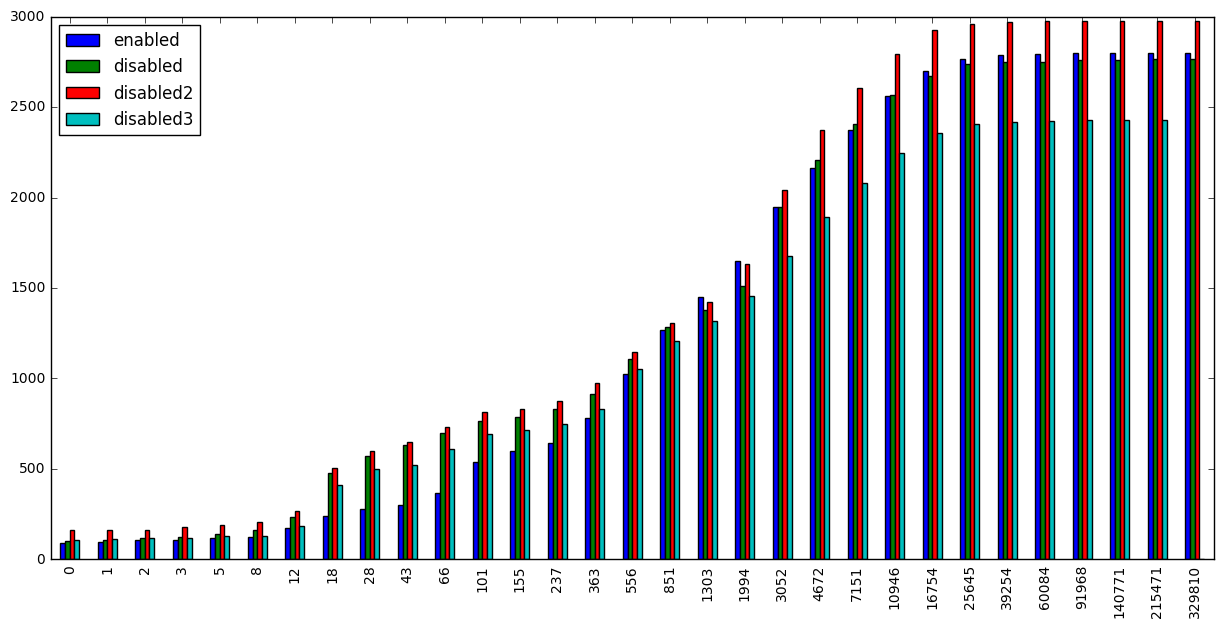

In [184]:
df = pd.DataFrame()
df['enabled'] = check_aggregated_enabled
df['disabled'] = check_aggregated_disabled
df['disabled2'] = check_aggregated_disabled2
df['disabled3'] = check_aggregated_disabled3

#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.cumsum().plot(kind='bar', figsize=(15, 7))
df

#df

We can also aggregate the values of the parent and children processes:

In [ ]:
plt.title('GC_MARK_MS')
(aggregated_content + aggregated_parent).plot(kind='bar', figsize=(15, 7))

Keyed histograms follow a similar pattern. To extract a keyed histogram for which we know the key/label we are interested in:

In [ ]:
keyed_hist = (
    pings_dataset
    .select(redirects='payload.keyedHistograms.NETWORK_HTTP_REDIRECT_TO_SCHEME.https.values')
    .records(sc, sample=0.05)
)

Add up the counts of every ping and plot it:

In [ ]:
aggregated = (
    keyed_hist
    .filter(lambda p: p['redirects'] is not None)
    .map(lambda p: pd.Series(p['redirects']))
    .reduce(lambda c1, c2: c1 + c2)
)

In [ ]:
aggregated.plot(kind='bar', figsize=(15, 7))